In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import matplotlib.animation as animation
import glob, re

import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

In [2]:
def generate_hetmap_imshow(ax, X, Y, Z, minZ=None, maxZ=None, cmap='jet', logscale=False, save=None, isolines=None):
    if minZ is None:
        minZ = np.nanmin(Z)
    if maxZ is None:
        maxZ = np.nanmax(Z)
    if logscale:
        norm = colors.LogNorm(vmin=minZ, vmax=maxZ)
    else:
        norm = colors.Normalize(vmin=minZ, vmax=maxZ)
    im = ax.imshow(Z, cmap=cmap, norm=norm, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], aspect='auto', origin='lower', interpolation='gaussian')
    ax.set_xlabel('Length [$\mu$m]')
    ax.set_ylabel('log(Doping) [log cm$^{-3}$]')
    # ax.set_title('Cost function')
    fig.colorbar(im, ax=ax)

In [3]:
DIR = "../build/ParticleSwarmResults"
part_files = glob.glob(DIR + "/part*.csv")
part_files.sort(key=lambda f: int(re.sub('\D', '', f)))

print(f"Found {len(part_files)} files")

Found 0 files


In [42]:
NbPart = len(part_files)
Data0 = np.loadtxt(part_files[0], delimiter=',', skiprows=1)
print(Data0.shape)
# Data is iter, x0, x1, ..., xN, v0, v1, ..., vN, best_x0, best_x1, ..., best_xN, best_f
Dim = int((Data0.shape[1] - 2) / 3)
NbIter = Data0.shape[0]
print(f"Dimension: {Dim}, NbIter: {NbIter}")

NB_PART = len(part_files)
NbPart = NB_PART
part_files = part_files[:NB_PART]

X = np.zeros((NbIter, NbPart, Dim))
V = np.zeros((NbIter, NbPart, Dim))
BestX = np.zeros((NbIter, NbPart, Dim))
BestF = np.zeros((NbIter, NbPart))

for i, f in enumerate(part_files):
    Data = np.loadtxt(f, delimiter=',', skiprows=1)
    X[:,i,:] = Data[:,1:Dim+1]
    V[:,i,:] = Data[:,Dim+1:2*Dim+1]
    BestX[:,i,:] = Data[:,2*Dim+1:3*Dim+1]
    BestF[:,i] = Data[:,3*Dim+1]

    

(201, 8)
Dimension: 2, NbIter: 201


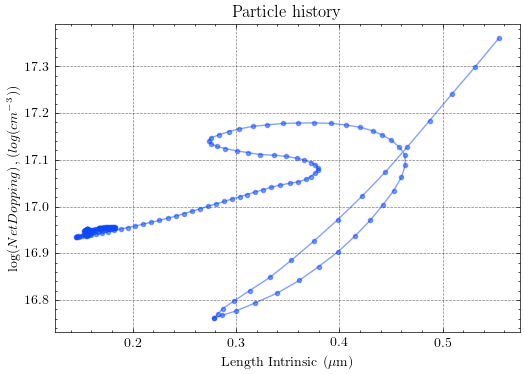

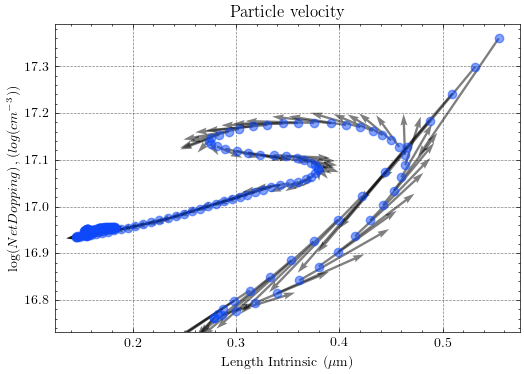

In [58]:
# Plot the history of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Length Intrinsic ($\mu$m)")
ax.set_ylabel("$\log(NetDopping) \,, (log(cm^{-3}))$")
ax.set_title("Particle history")
ax.plot(X[:,0,0], X[:,0,1], '.-', alpha=0.5, label="Position")

# Quiver plot of the velocity of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Length Intrinsic ($\mu$m)")
ax.set_ylabel("$\log(NetDopping) \,, (log(cm^{-3}))$")
ax.set_title("Particle velocity")
ax.quiver(X[:,0,0], X[:,0,1], V[:,0,0], V[:,0,1], alpha=0.5, label="Velocity", scale=10, scale_units='xy', angles='xy', width=0.005)
ax.scatter(X[:,0,0], X[:,0,1], alpha=0.5, label="Position")


-71.1278 10000000000.0


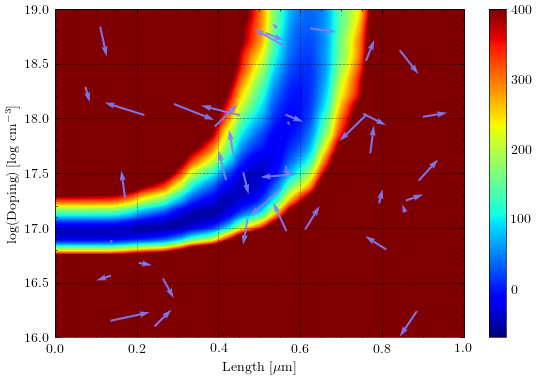

Animation: 200/201

In [49]:
# Animate the particles

BnD = 12
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Length Intrinsic ($\mu$m)")
ax.set_ylabel("$\log(NetDopping) \,, (log(cm^{-3}))$")
# ax.set_title("Particle swarm")
ax.set_xlim(0, 1.)
ax.set_ylim(16, 19)
# ax.set_aspect('equal')
fig.tight_layout()

line, = ax.plot([], [], '.', alpha=0.8, markersize=4, color='#66e0ff', markeredgecolor='k')
qr = ax.quiver(X[0,:,0], X[0,:,1], V[0,:,0], V[0,:,1], color='#8080ff',
               alpha=0.9, angles='xy', scale_units='xy', scale=10,
              width=0.005)

# Add cost function as background
file = "../build/main_cost_function2.csv"
length_intrinsic, doping_acceptor, BV, BP, DW, BV_COST, BP_COST, DW_COST, COST = np.loadtxt(file, delimiter=',', unpack=True, skiprows=1)

unique_length_intrinsic = np.unique(length_intrinsic)
unique_doping_acceptor = np.unique(doping_acceptor)
ISO = False
Xm, Ym = np.meshgrid(unique_length_intrinsic, unique_doping_acceptor)
COSTs = COST.reshape(len(unique_length_intrinsic), len(unique_doping_acceptor)).T
generate_hetmap_imshow(ax, Xm, Ym, COSTs, None, 400, cmap='jet', logscale=False, save='COST_heatmap.pdf', isolines=ISO)
print(np.nanmin(COSTs), np.nanmax(COSTs))

def init():
    line.set_data([], [])
    return line,

def animate(i):
    print(f"\rAnimation: {i}/{NbIter}", end="")
    line.set_data(X[i,:,0], X[i,:,1])
    qr.set_offsets(X[i,:,:])
    qr.set_UVC(V[i,:,0], V[i,:,1])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=100, blit=True)
plt.show()
anim.save('../build/ParticleSwarmAnimation.mp4', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

In [51]:
global_hist = "../build/ParticleSwarmResults/global_swarm.csv"
iteration,best_x_00,best_x_01,best_fitness = np.loadtxt(global_hist, skiprows=1, delimiter=",", unpack=True)

Text(0, 0.5, 'Cost function')

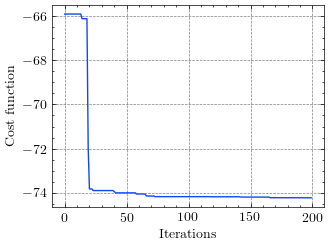

In [54]:
fig, ax = plt.subplots()
ax.plot(iteration, best_fitness)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost function")

(16.0, 19.0)

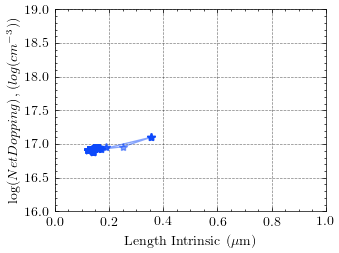

In [57]:
fig, ax = plt.subplots()
ax.plot(best_x_00[, best_x_01, '*-', alpha=0.5)
ax.set_xlabel("Length Intrinsic ($\mu$m)")
ax.set_ylabel("$\log(NetDopping) \,, (log(cm^{-3}))$")
# ax.set_title("Particle swarm")
ax.set_xlim(0, 1.)
ax.set_ylim(16, 19)